## basics

- LLM.int8(): 8-bit Matrix Multiplication for Transformers at Scale
    - https://arxiv.org/abs/2208.07339
- 作者也是开源库：bitsandbytes 的作者
    - https://github.com/TimDettmers/bitsandbytes

- int8:
    - -128, 127

## 一个计算示例

In [1]:
from IPython.display import Image

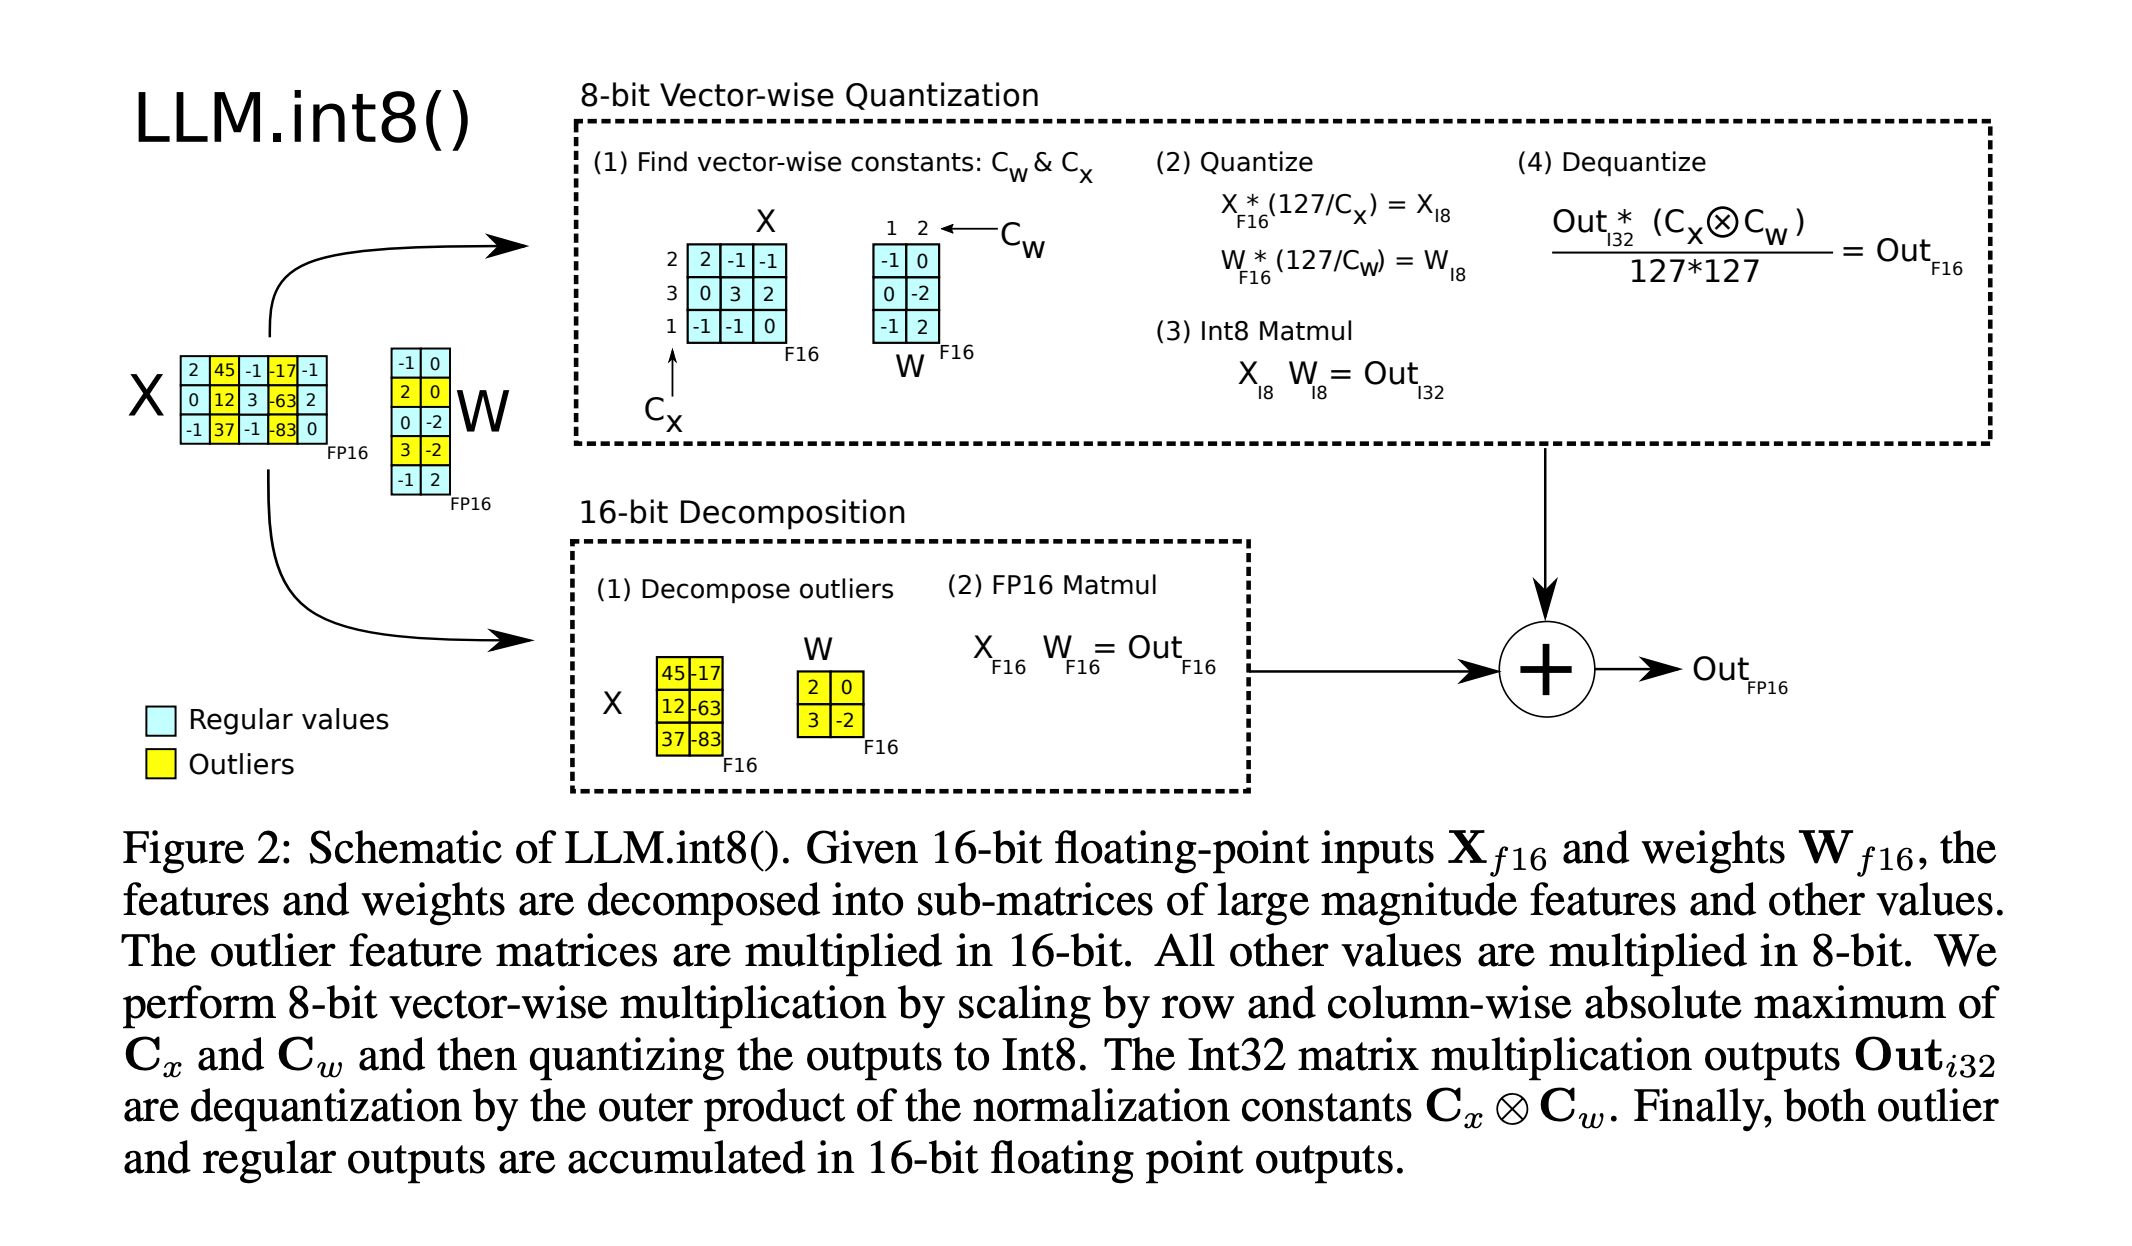

In [2]:
Image('../imgs/llm-int8.png')

In [3]:
import numpy as np

In [8]:
# 列为特征，行为样本
X = np.asarray([[2, 45, -1, -17, -1], 
                [0, 12, 3, -63, 2], 
                [-1, 37, -1, -83, 0]], )
W = np.asarray([[-1, 0], 
                [2, 0], 
                [0, -2], 
                [3, -2], 
                [-1, 2]])

In [6]:
# (3, 5) * (5, 2) ==> (3, 2)
# ground truth
X.dot(W)

array([[  38,   34],
       [-167,  124],
       [-174,  168]])

In [10]:
X_reg = X[:, [0, 2, 4]]
W_reg = W[[0, 2, 4], :]
X_out = X[:, [1, 3]]
W_out = W[[1, 3], :]

### regular parts (small values) => 8bit quant

In [14]:
X_reg

array([[ 2, -1, -1],
       [ 0,  3,  2],
       [-1, -1,  0]])

In [21]:
np.max(np.abs(X_reg), axis=0)

array([2, 3, 2])

In [20]:
W_reg

array([[-1,  0],
       [ 0, -2],
       [-1,  2]])

####  vector-wise constants

In [27]:
# 行最大（振幅）
Cx = np.max(np.abs(X_reg), axis=1)[:, np.newaxis]
# 列最大（振幅）
Cw = np.max(np.abs(W_reg), axis=0)[np.newaxis, :]

#### quantize

In [45]:
# element-wise 乘法
X_i8 = X_reg * (127/Cx)
W_i8 = W_reg * (127/Cw)

#### int8 matmul

In [36]:
Out_i32 = X_i8.dot(W_i8)

#### dequant

In [38]:
Cx.shape

(3, 1)

In [40]:
Cw.shape

(1, 2)

In [41]:
np.kron(Cx, Cw)

array([[2, 4],
       [3, 6],
       [1, 2]])

In [53]:
# element-wise 乘法
Out_f16_1 = Out_i32 * (np.kron(Cx, Cw)) / (127*127)
Out_f16_1

array([[-1.,  0.],
       [-2., -2.],
       [ 1.,  2.]])

In [47]:
X_reg.dot(W_reg)

array([[-1,  0],
       [-2, -2],
       [ 1,  2]])

### 16-bit

In [55]:
Out_f16_2 = X_out.dot(W_out)

In [56]:
Out_f16_1 + Out_f16_2

array([[  38.,   34.],
       [-167.,  124.],
       [-174.,  168.]])